In [51]:
from sklearn.datasets import make_circles

n_samples = 1000

X, Y = make_circles(n_samples= n_samples, noise=0.03, random_state=42)

In [52]:
len(X), len(Y)

(1000, 1000)

In [53]:
X[:5], Y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [54]:
import pandas as pd
circles_df = pd.DataFrame({"X1": X[:, 0], "X2" : X[:,1], "Y":Y[:]})
circles_df[:10]

,X1,X2,Y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


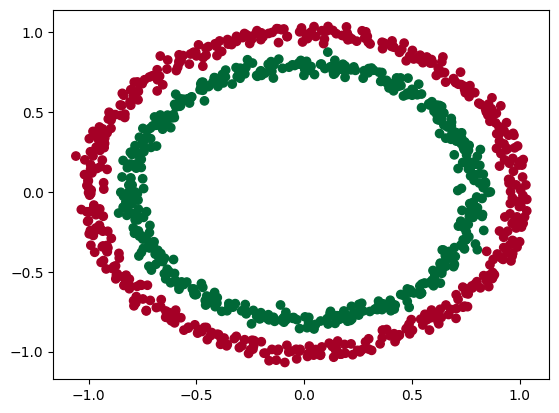

In [55]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0], y = X[:,1], c=Y ,cmap=plt.cm.RdYlGn)

In [56]:
import torch
torch.__version__

'2.2.2+cu121'

In [57]:
# Data to Tensors
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)


In [58]:
X[:3], Y[:3]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733]]),
 tensor([1., 1., 1.]))

In [59]:
type(X), X.shape, X.dim

(torch.Tensor, torch.Size([1000, 2]), <function Tensor.dim>)

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
type(X_test)

torch.Tensor

In [61]:
len(X_train), len(X_test),len(Y_train), len(Y_test)

(800, 200, 800, 200)

In [62]:
from torch import nn
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")

CUDA is available.


In [63]:
class CircleModel0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=2)
        self.layer2 = nn.Linear(in_features=2, out_features=1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

model0  = CircleModel0().to("cuda")

In [64]:
next(model0.parameters()).device

device(type='cuda', index=0)

In [65]:
model0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496]], device='cuda:0')),
             ('layer1.bias', tensor([-0.1549,  0.1427], device='cuda:0')),
             ('layer2.weight', tensor([[-0.3443,  0.4153]], device='cuda:0')),
             ('layer2.bias', tensor([0.6233], device='cuda:0'))])

In [66]:
X_test = X_test.to("cuda")
untrained_preds = model0(X_test)
print(f"Length of predection: {len(untrained_preds)}, Shape:{untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape:{X_test.shape}")
print(f"\nFirst 10 predections:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{Y_test[:10]}")


Length of predection: 200, Shape:torch.Size([200, 1])
Length of test samples: 200, Shape:torch.Size([200, 2])

First 10 predections:
tensor([[0.8778],
        [0.7970],
        [0.8938],
        [0.8741],
        [0.5830],
        [0.5361],
        [0.5550],
        [0.4931],
        [0.9069],
        [0.7882]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


                                         <---------------------------------------------------------------------------->                                                                 
For regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how wrong your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

                                         <---------------------------------------------------------------------------->                                                                

In [67]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),lr=0.1)


In [68]:
def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item()
    acc = (correct/len(y_preds)) *1000
    return acc

<h3>PyTorch training loop</h3>
1. Forward Pass <br>
2. Caluate loss <br>
3. Zero Gradients <br>
4. Preform Backprop on loasss <br>
5. step the optimizer(gradient descent) <br>

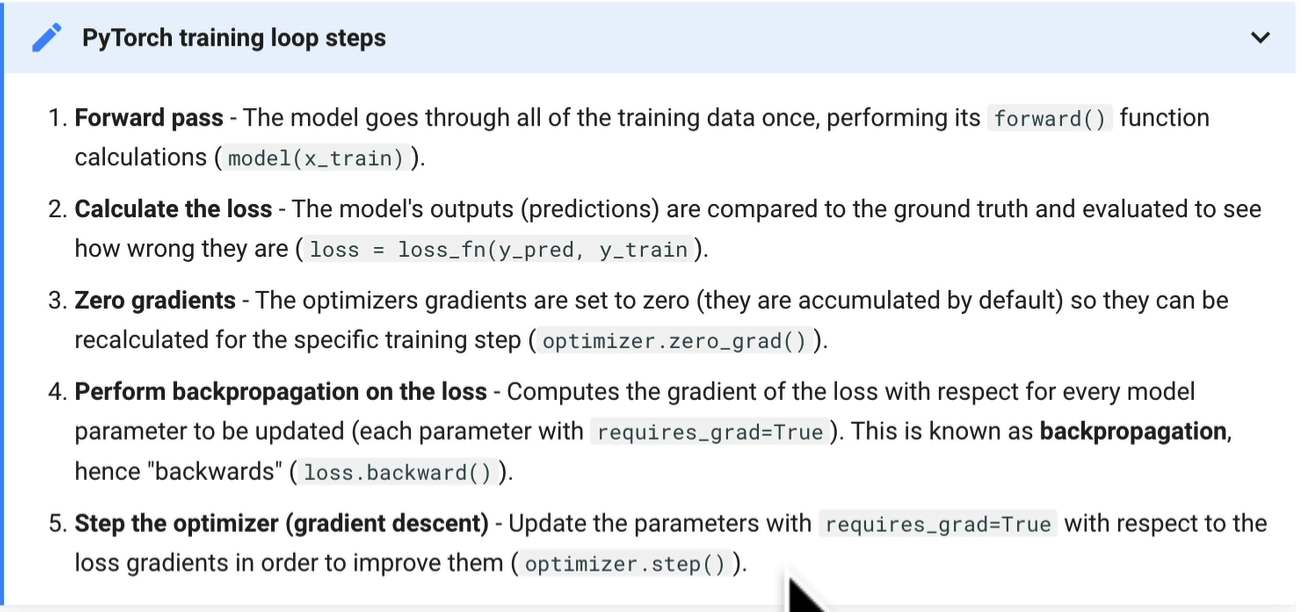

In [69]:
# Checking model with out training for this using model.eval and inference mode to avoid training

model0.eval()
with torch.inference_mode():
    y_logits = model0(X_test)[:5]
y_logits    

tensor([[0.8778],
        [0.7970],
        [0.8938],
        [0.8741],
        [0.5830]], device='cuda:0')

In [70]:
# using sigmoid with on logits
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.7064],
        [0.6893],
        [0.7097],
        [0.7056],
        [0.6418]], device='cuda:0')

In [71]:
# Just to show concept sigmoid activation functuion trains model
torch.round(y_preds_probs), Y_test[:5]

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

<h3>Building Training Loop</h3>

In [73]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, Y_train = X_train.to("cuda"), Y_train.to("cuda")
X_test, Y_test = X_test.to("cuda"), Y_test.to("cuda")

for epoch in range(epochs):
    #Trining
    model0.train()

    #Forward pass
    y_logits = model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #Calculate loss
    loss = loss_fn(y_logits, Y_train)

    acc = accuracy_fn(y_true = Y_train, y_preds = y_pred)

    #Optimizer
    optimizer.zero_grad()

    #Loss backward
    loss.backward()

    #optimizer step (gradient descent)
    optimizer.step()

    model0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss
        test_loss = loss_fn(Y_test, test_pred)

        test_acc = accuracy_fn(y_true= Y_test, y_preds= test_pred)

    #print test
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}% ")


Epoch: 0 | Loss: 0.69456, Acc: 502.50% | Test loss: 0.68320 | Test acc: 535.00% 
Epoch: 10 | Loss: 0.69441, Acc: 500.00% | Test loss: 0.68320 | Test acc: 535.00% 
Epoch: 20 | Loss: 0.69429, Acc: 496.25% | Test loss: 0.69320 | Test acc: 535.00% 
Epoch: 30 | Loss: 0.69419, Acc: 496.25% | Test loss: 0.69320 | Test acc: 535.00% 
Epoch: 40 | Loss: 0.69411, Acc: 493.75% | Test loss: 0.69820 | Test acc: 530.00% 
Epoch: 50 | Loss: 0.69404, Acc: 491.25% | Test loss: 0.70820 | Test acc: 520.00% 
Epoch: 60 | Loss: 0.69397, Acc: 495.00% | Test loss: 0.70820 | Test acc: 525.00% 
Epoch: 70 | Loss: 0.69392, Acc: 495.00% | Test loss: 0.71320 | Test acc: 520.00% 
Epoch: 80 | Loss: 0.69387, Acc: 495.00% | Test loss: 0.71320 | Test acc: 520.00% 
Epoch: 90 | Loss: 0.69382, Acc: 492.50% | Test loss: 0.71820 | Test acc: 515.00% 
